<a href="https://colab.research.google.com/github/manvgom/Pickioset/blob/main/EfficientNetB0_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
import numpy as np
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import cv2
import os

In [20]:
#Definir categorias
ds_path = os.listdir('drive/MyDrive/MTDI_TFM/PICKIOSET/dataset')
print (ds_path)
print("Types of classes labels found: ", len(ds_path))

['fanta_limon', 'hummus_pimiento', 'gazpacho', 'crema_calabaza', 'botella_agua', 'coca_cola', 'ensalada_rusa', 'fanta_naranja', 'ensalada_cangrejo', 'guisantes_jamon', 'smoothie_mango', 'paella', 'manzana', 'snack_integral', 'smoothie_fresa', 'sandwich_jamon', 'tortilla_patata', 'yogurth_cereal']
Types of classes labels found:  18


In [21]:
#Generar dataframe con muestras y categorias
class_labels = []
for item in ds_path:
 all_classes = os.listdir('drive/MyDrive/MTDI_TFM/PICKIOSET/dataset' + '/' +item)
 for room in all_classes:
  class_labels.append((item, str('ds_path' + '/' +item) + '/' + room))
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
df

,Labels,image
0,fanta_limon,ds_path/fanta_limon/fantalimon_98.jpg
1,fanta_limon,ds_path/fanta_limon/fantalimon_97.jpg
2,fanta_limon,ds_path/fanta_limon/fantalimon_99.jpg
3,fanta_limon,ds_path/fanta_limon/fantalimon_96.jpg
4,fanta_limon,ds_path/fanta_limon/fantalimon_100.jpg
...,...,...
1795,yogurth_cereal,ds_path/yogurth_cereal/yogurth_10.jpg
1796,yogurth_cereal,ds_path/yogurth_cereal/yogurth_3.jpg
1797,yogurth_cereal,ds_path/yogurth_cereal/yogurth_5.jpg
1798,yogurth_cereal,ds_path/yogurth_cereal/yogurth_1.jpg


In [22]:
 #Número de muestras por categoria
print("Total number of images in the dataset: ", len(df))
label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  1800
fanta_limon          100
hummus_pimiento      100
tortilla_patata      100
sandwich_jamon       100
smoothie_fresa       100
snack_integral       100
manzana              100
paella               100
smoothie_mango       100
guisantes_jamon      100
ensalada_cangrejo    100
fanta_naranja        100
ensalada_rusa        100
coca_cola            100
botella_agua         100
crema_calabaza       100
gazpacho             100
yogurth_cereal       100
Name: Labels, dtype: int64


In [23]:
#Escalar las imagenes
path = 'drive/MyDrive/MTDI_TFM/PICKIOSET/dataset/'
dataset_path = os.listdir('drive/MyDrive/MTDI_TFM/PICKIOSET/dataset')
  
img_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(i)

In [24]:
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(1800, 224, 224, 3)

In [25]:
#Preparar variables categóricas
y=df['Labels'].values
print(list(dict.fromkeys(y)))
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (list(dict.fromkeys(y)))


['fanta_limon', 'hummus_pimiento', 'gazpacho', 'crema_calabaza', 'botella_agua', 'coca_cola', 'ensalada_rusa', 'fanta_naranja', 'ensalada_cangrejo', 'guisantes_jamon', 'smoothie_mango', 'paella', 'manzana', 'snack_integral', 'smoothie_fresa', 'sandwich_jamon', 'tortilla_patata', 'yogurth_cereal']
[5, 9, 7, 2, 0, 1, 4, 6, 3, 8, 14, 11, 10, 15, 13, 12, 16, 17]


In [26]:
y=y.reshape(-1,1)
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()
print(Y[:])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [27]:
#Preparar dataset y separar conjunto de entrenamiento y validación
images, Y = shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)



(1710, 224, 224, 3)
(1710, 18)
(90, 224, 224, 3)
(90, 18)


In [28]:
#Implementar EfficientNet
NUM_CLASSES = 18
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )
model.summary()
#En este ds tarda 1 min por epoch. En el original son 30 min por epoch.
hist = model.fit(train_x, train_y, epochs=30, verbose=2) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 18)               4072629   
                                                                 
Total params: 4,072,629
Trainable params: 4,030,606
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/30
54/54 - 51s - loss: 2.7490 - accuracy: 0.2713 - 51s/epoch - 941ms/step
Epoch 2/30
54/54 - 38s - loss: 1.0770 - accuracy: 0.6795 - 38s/epoch - 711ms/step
Epoch 3/30
54/54 - 38s - loss: 0.3838 - accuracy: 0.8901 - 38s/epoch - 712ms/step
Epoch 4/30
54/54 - 39s - loss: 0.5689 - accuracy: 0.8825 - 39s/epoch - 716ms/step
Epoch 5/30
54/54 - 39s - loss: 0.1777 - accuracy: 0.9491 - 39s/epoch - 717ms/step
Epoch 6/30
54/54 - 38s - loss:

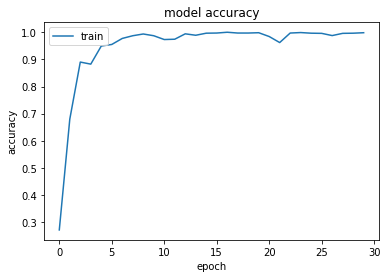

In [29]:
#Precisión en cada entrenamiento
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(hist)

In [30]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 3s 620ms/step - loss: 11.0275 - accuracy: 0.4333
Loss = 11.027514457702637
Test Accuracy = 0.4333333373069763


Input image shape: (1, 224, 224, 3)


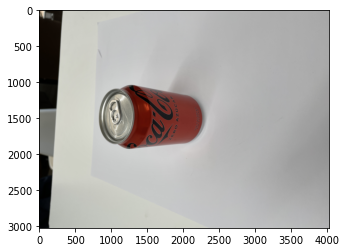

In [31]:
img_path = 'drive/MyDrive/MTDI_TFM/PICKIOSET/originales/IMG_8406.JPG'
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [33]:
print (ds_path)
preds=model.predict(x)
preds  

['fanta_limon', 'hummus_pimiento', 'gazpacho', 'crema_calabaza', 'botella_agua', 'coca_cola', 'ensalada_rusa', 'fanta_naranja', 'ensalada_cangrejo', 'guisantes_jamon', 'smoothie_mango', 'paella', 'manzana', 'snack_integral', 'smoothie_fresa', 'sandwich_jamon', 'tortilla_patata', 'yogurth_cereal']


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)